In [1]:
%matplotlib inline
# Imports
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import tqdm

/usr/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/

In [2]:
# Configs
plt.style.use('fivethirtyeight')
torch.manual_seed(0)
np.random.seed(0)
img_dir = './Data'

num_epochs = 50 # Number of training epochs at each model size

# Learning rate/Beta
lr_gen = 0.0002
lr_dis = 0.0004
beta1 = 0.5

resolution = 128
batch_size = 256

nz = 128

num_workers = 10

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("Cuda is unavailable")
    device = torch.device("cpu")

In [3]:
# Define our data loader
# https://pytorch.org/vision/stable/transforms.html
class ImageDataset(Dataset):
    def __init__(self, img_dir, target_size):
        self.img_dir = img_dir
        self.transform = v2.Compose([
            v2.Resize(size=(target_size, target_size), antialias=True),
            transforms.ConvertImageDtype(torch.float),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize inputs, standard vals for images
        ])
        self.imageLabels = os.listdir(img_dir)
        self.target_size = target_size

    def __len__(self):
        return len(self.imageLabels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imageLabels[idx])
        image = torchvision.io.read_image(img_path)
        image = self.transform(image)
        return image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

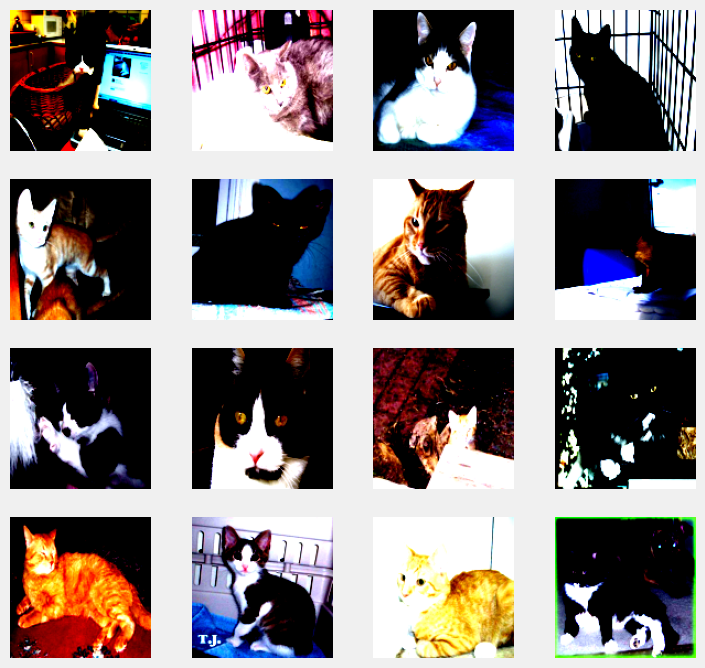

In [4]:
# Test the image loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = ImageDataset(img_dir, 128)

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

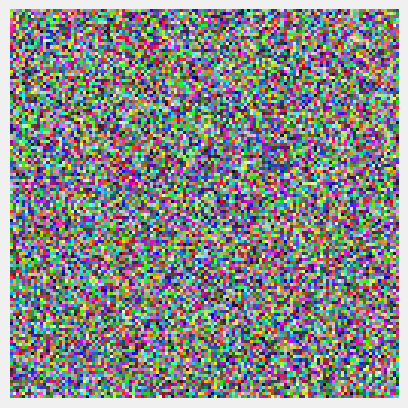

In [5]:
def generate_random_vector(shape: torch.Size):
    """
    Generate a random image with channels, width, and height defined by shape
    This is useful for testing that the discriminator can receive the correct inputs and outputs
    """
    channels = shape[0]
    width = shape[1]
    height = shape[2]
    return np.random.rand(channels, width, height)
img = generate_random_vector(training_data[0].shape)
plt.axis('off')
plt.imshow(torch.permute(torch.from_numpy(img), (1, 2, 0)))

In [6]:
class DiscriminatorLayerBundle():
    def __init__(self, input_size: int, output_size = 0):
        if (output_size == 0):
            output_size = 2*input_size
        self.layers = [
            torch.nn.Conv2d(input_size, output_size, 4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(output_size),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ]
            
    def getLayers(self):
        return self.layers

class Discriminator(torch.nn.Module):
    def __init__(self, number_channels = 3, dis_features = 32, layer_count=5):
        super(Discriminator, self).__init__()
        self.nn = torch.nn.Sequential()
        self.layers = [
            torch.nn.Conv2d(number_channels, dis_features, 4, stride=2, padding=1, groups=1, bias=True),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ]

        resolution = dis_features
        for i in range(1, layer_count):
            nextLayers = DiscriminatorLayerBundle(resolution)
            for layer in nextLayers.getLayers():
                self.layers.append(layer)
            resolution *= 2

        self.layers.extend([
            torch.nn.Conv2d(resolution, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
            torch.nn.Sigmoid()
        ])

        for count, layer in enumerate(self.layers):
            self.nn.add_module(str(count), layer)
        

    def forward(self, x):
        return self.nn(x)

import torch.nn as nn


In [15]:
class GeneratorLayerBundle():
    def __init__(self, input_size: int, output_size = 0,):
        if (output_size == 0):
            output_size = input_size/2
        self.layers = [
            torch.nn.ConvTranspose2d(input_size, output_size, 4, 2, 1),
            torch.nn.BatchNorm2d(output_size),
            torch.nn.ReLU(True)
        ]
            
    def getLayers(self):
        return self.layers

ngf=128
class Generator(torch.nn.Module):
    def __init__(self, output_size: int, generator_input_size: int, layer_count = 5, number_channels = 3):
        super(Generator, self).__init__()

        self.nn = torch.nn.Sequential()
        
        resolution = output_size*2**(layer_count-1)
        
        self.layers = [
            nn.ConvTranspose2d(128, 128 * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
        ]

        for i in range(1, layer_count, 1):
            new_layers = GeneratorLayerBundle(resolution, resolution//2)
            resolution //= 2
            for layer in new_layers.getLayers():
                self.layers.append(layer)

        # Add final layers
        self.layers.append(
            torch.nn.ConvTranspose2d(128, 3, 4, 2, 1, bias = False),
        )
        self.layers.append(
            torch.nn.Tanh()
        )
        
        for count, layer in enumerate(self.layers):
            self.nn.add_module(str(count), layer)
        
    def forward(self, x):
        return self.nn(x)

In [12]:
# Initialize weights for generator and discriminator
# From https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [13]:
def train(netG, netD, dataloader, num_epochs, device, criterion, optimizerD, optimizerG):   
    nz = 128
    real_label = 1.
    fake_label = 0
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    
    print("Starting Training Loop...")
    # For each epoch
    for epoch in tqdm.trange(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data.to(torch.float32).to(device)

            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
    
            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
    
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
    
            # Output training stats
            if i % 500 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
    
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
            iters += 1
    return (netG, netD, img_list)
def evaluate(generator):
    pass

In [16]:
discriminator = Discriminator().to(device)
print(discriminator)
generator = Generator(nz, ngf).to(device)
print(generator)

discriminator.apply(weights_init)
generator.apply(weights_init)

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
loss = torch.nn.BCELoss()

discriminator_optimizer = torch.optim.SGD(discriminator.parameters(), lr=lr_dis)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))

training_data = ImageDataset(img_dir, resolution)
dataloader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)

generator, discriminator, img_list = train(generator, discriminator, dataloader, num_epochs, device, loss, discriminator_optimizer, generator_optimizer)

Discriminator(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

  0%|                                                                                                                                                                                                              | 0/50 [00:00<?, ?it/s]

[0/50][0/79]	Loss_D: 2.0868	Loss_G: 0.6023	D(x): 0.6107	D(G(z)): 0.7069 / 0.6033


  2%|███▉                                                                                                                                                                                                  | 1/50 [00:33<27:06, 33.18s/it]

[1/50][0/79]	Loss_D: 4.2972	Loss_G: 4.1111	D(x): 0.0868	D(G(z)): 0.6924 / 0.0188


  2%|███▉                                                                                                                                                                                                  | 1/50 [00:37<30:17, 37.09s/it]


KeyboardInterrupt: 

In [ ]:
interval = len(img_list) // 10

for count, img in enumerate(img_list):
    if (count % interval == 0):
        plt.axis("off")
        plt.imshow(torch.permute(img, (1, 2, 0)))
        plt.savefig(f'img_{count}.png')
        plt.show()